# Response_3: Machine Learning Modeling

### Table of Contents
- [1. Load Data](#1-load-data)  

- [2. Data preprocessing](#2-data-preprocessing)  
    - [2.1 Splite data](#21-splite-data)  
    - [2.2 Standard scaling](#21-standard-scaling) 

- [3. Machine learning model training](#3-machine-learning-model-training)  
    - [3.0 Help function](#30-help-function)
    - [3.1 Logistic Regression](#31-logistic-regression)
        [Analyze the probabilities](analyze-the-probabilities)
        [Feature significance analysis](feature-significance-analysis)
    - [3.2 SVC](#32-SVC)
    - [3.3 Ensemble: RandomForest](#33-ensemble-randomforest)
    - [3.4 Ensemble: XGBoost](#34-ensemble-xgboost)


In [297]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import altair as alt

from time import time

In [298]:
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix, accuracy_score, recall_score, f1_score, precision_score

### 1. Load data

In [299]:
df = pd.read_csv('datasets/feature_target.csv')

In [300]:
df = df.iloc[:,1:]
# remove the last column "Linguistic Quality"

In [301]:
df.head()

,score,response_length,mean_sentence_length,grammer_error,readability,type_token_ratio,coherence,sentiment,Clarity of the Challenge,Impact Explanation,Lesson Learned,Depth of Reflection
0,3,110,20.333333,0.000000,78.28,0.647541,0.487087,0.999572,1,1,1,1
1,3,70,16.200000,0.001633,91.11,0.765432,0.321876,-0.986382,1,1,1,1
2,3,135,16.888889,0.000110,56.25,0.625000,0.492450,0.997921,2,1,2,1
3,2,109,19.000000,0.000000,47.18,0.684211,0.308484,0.994910,1,1,1,1
4,3,53,15.250000,0.002136,49.52,0.721311,0.434561,-0.989042,2,1,1,1


### 2. Data preprocessing

#### 2.1 Split data

In [302]:
X = df.iloc[:,1:]
y = df['score']

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)

#### 2.2 Standard scaling

In [304]:
from sklearn.preprocessing import StandardScaler

In [305]:
ss= StandardScaler()
X_train_scaled = ss.fit_transform(X_train)

### 3. Machine learning model training

#### 3.0 Help function

In [306]:
def quadratic_weighted_kappa(y_true, y_pred, min_rating=1, max_rating=5):
    """
    Compute the Quadratic Weighted Kappa (QWK) score, a measure of agreement between two ordinal ratings. QWK accounts for the severity of disagreements using a quadratic weight matrix.

    Parameters:
    -----------
    y_true : array-like of shape (n_samples,)
        Ground truth ratings.
    y_pred : array-like of shape (n_samples,)
        Predicted ratings.
    min_rating : int, optional (default=1)
        Minimum possible rating.
    max_rating : int, optional (default=5)
        Maximum possible rating.

    Returns:
    --------
    float
        Quadratic Weighted Kappa score (1 indicates perfect agreement, 
        0 indicates random agreement, and negative values indicate worse-than-random agreement).
    """

    # Define rating range
    ratings = np.arange(min_rating, max_rating + 1)
    num_ratings = len(ratings)

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=ratings).astype(np.float64)
    
    # Normalize confusion matrix to probability distribution
    cm /= cm.sum()

    # Compute expected matrix under independence assumption
    row_marginals = cm.sum(axis=1, keepdims=True)
    col_marginals = cm.sum(axis=0, keepdims=True)
    expected_matrix = row_marginals @ col_marginals  # Outer product
    expected_matrix /= expected_matrix.sum()

    # Construct quadratic weight matrix
    weight_matrix = np.square(np.subtract.outer(ratings, ratings)) / (num_ratings - 1) ** 2

    # Compute QWK score
    numerator = np.sum(weight_matrix * cm)
    denominator = np.sum(weight_matrix * expected_matrix)

    return 1 - (numerator / denominator)

#### 3.1. Logistic regression 

In [307]:
from sklearn.linear_model import LogisticRegression

In [308]:
from sklearn.metrics import make_scorer

qwk_scorer = make_scorer(quadratic_weighted_kappa, greater_is_better=True)

In [309]:
%%time

lr = LogisticRegression(
    multi_class = 'multinomial', 
    solver = 'lbfgs',
    penalty = 'l2',
    max_iter = 5000,
    random_state=21
    )

param_grid = {
    'C':[0.1, 1, 10, 100, 1000],

}

sss = StratifiedShuffleSplit(n_splits=5, random_state=21)

search_lr = GridSearchCV(
    lr,
    param_grid=param_grid,
    cv=sss,
    verbose=1,
    scoring = qwk_scorer
)

search_lr.fit(X_train_scaled, y_train)


Fitting 5 folds for each of 5 candidates, totalling 25 fits
CPU times: user 490 ms, sys: 86.7 ms, total: 577 ms
Wall time: 733 ms


GridSearchCV(cv=StratifiedShuffleSplit(n_splits=5, random_state=21, test_size=None,
            train_size=None),
             estimator=LogisticRegression(max_iter=5000,
                                          multi_class='multinomial',
                                          random_state=21),
             param_grid={'C': [0.1, 1, 10, 100, 1000]},
             scoring=make_scorer(quadratic_weighted_kappa), verbose=1)

In [310]:
search_lr.best_params_

{'C': 0.1}

In [311]:
y_test_prediction = search_lr.best_estimator_.predict(ss.transform(X_test))

In [312]:
y_test_prediction_probability = search_lr.best_estimator_.predict_proba(ss.transform(X_test))

In [313]:
y_test_prediction_probability.shape

(300, 5)

In [314]:
y_test_prediction

array([2, 3, 4, 3, 3, 4, 3, 5, 5, 3, 4, 3, 3, 3, 3, 3, 3, 5, 3, 2, 3, 3,
       3, 2, 3, 4, 4, 4, 5, 2, 3, 5, 4, 5, 3, 5, 5, 4, 3, 3, 3, 2, 3, 5,
       3, 2, 3, 3, 3, 3, 5, 4, 3, 2, 3, 4, 3, 3, 2, 3, 3, 2, 3, 3, 5, 4,
       2, 3, 3, 4, 2, 3, 5, 3, 4, 2, 3, 2, 5, 4, 3, 4, 4, 2, 2, 2, 3, 4,
       2, 5, 5, 2, 4, 3, 2, 3, 3, 5, 3, 3, 3, 3, 4, 4, 5, 4, 3, 3, 3, 3,
       4, 2, 2, 3, 4, 2, 3, 4, 3, 4, 3, 2, 2, 3, 3, 3, 4, 3, 4, 3, 3, 5,
       3, 4, 2, 3, 2, 3, 5, 2, 5, 3, 4, 3, 4, 5, 3, 5, 4, 3, 3, 2, 4, 3,
       4, 3, 2, 3, 3, 4, 4, 4, 3, 3, 4, 3, 3, 3, 3, 3, 4, 2, 3, 2, 2, 3,
       4, 4, 3, 2, 3, 3, 3, 4, 4, 3, 4, 4, 3, 5, 3, 3, 3, 2, 5, 2, 4, 3,
       3, 4, 4, 4, 4, 2, 5, 4, 5, 5, 3, 3, 4, 4, 3, 3, 3, 4, 2, 3, 5, 4,
       4, 3, 5, 3, 3, 4, 2, 4, 4, 4, 3, 3, 2, 3, 5, 2, 5, 3, 3, 3, 4, 2,
       3, 4, 2, 3, 2, 3, 3, 3, 3, 3, 3, 2, 2, 3, 3, 5, 2, 3, 3, 4, 3, 2,
       5, 4, 4, 3, 2, 2, 3, 5, 2, 3, 2, 3, 4, 3, 4, 3, 3, 5, 4, 3, 3, 2,
       3, 5, 3, 2, 3, 4, 3, 3, 2, 3, 3, 2, 3, 4])

In [315]:
def quadratic_weighted_kappa(y_true, y_pred, min_rating=1, max_rating=5):
    # Calculate confusion matrix
    cm = confusion_matrix(y_true, y_pred, labels=np.arange(min_rating, max_rating + 1))
    
    # Calculate weights
    num_ratings = max_rating - min_rating + 1
    weight_matrix = np.zeros((num_ratings, num_ratings))
    
    for i in range(num_ratings):
        for j in range(num_ratings):
            weight_matrix[i, j] = (i - j) ** 2 / (num_ratings - 1) ** 2
    
    # Normalize the confusion matrix to probabilities
    cm = cm.astype(float)
    cm = cm / cm.sum()
    
    # Calculate the expected matrix (probabilities of each class pair)
    expected_matrix = np.outer(cm.sum(axis=1), cm.sum(axis=0))
    expected_matrix = expected_matrix / expected_matrix.sum()
    
    # Compute the QWK score
    numerator = np.sum(weight_matrix * cm)
    denominator = np.sum(weight_matrix * expected_matrix)
    
    return 1 - numerator / denominator

In [316]:
quadratic_weighted_kappa(y_test, y_test_prediction)

0.5799461196710465

In [317]:
accuracy_score(y_test, y_test_prediction)

0.51

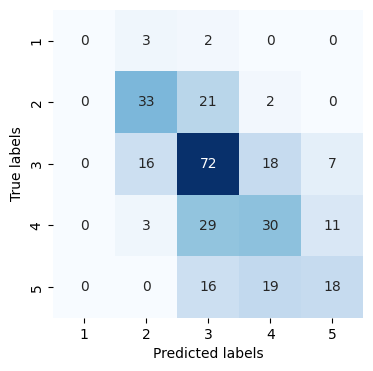

In [318]:
conf_matrix = confusion_matrix(y_test, y_test_prediction, labels=None, sample_weight=None, normalize=None)
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1,6), yticklabels=range(1,6), cbar=None)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

##### Analyze the probabilities

In [319]:
probability_df = pd.DataFrame(y_test_prediction_probability)
probability_df.head()

,0,1,2,3,4
0,0.065313,0.536450,0.344543,0.047294,0.006399
1,0.002255,0.027227,0.422155,0.377603,0.170760
2,0.005453,0.032788,0.241680,0.524624,0.195454
3,0.010512,0.186906,0.639134,0.114477,0.048971
4,0.008042,0.114553,0.573905,0.225172,0.078328


In [320]:
mask = probability_df.max(axis=1)>0.75

In [321]:
accuracy_list = []
sample_amount = []
QDK_list = []

for thres in [0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75]:
    mask = probability_df.max(axis=1)>=thres
    sample_amount.append(mask.sum())
    accuracy_list.append(accuracy_score(y_test.values[mask], y_test_prediction[mask]))
    QDK_list.append(quadratic_weighted_kappa(y_test.values[mask], y_test_prediction[mask]))


In [322]:
proba_thre_df = pd.DataFrame({
    'Probability threshold':[0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75],
    'Observation numers':sample_amount,
    'Accuracy': accuracy_list,
    'QDK':QDK_list,
})

In [323]:
proba_thre_df

,Probability threshold,Observation numers,Accuracy,QDK
0,0.30,300,0.510000,0.579946
1,0.35,300,0.510000,0.579946
2,0.40,289,0.508651,0.578822
3,0.45,243,0.506173,0.572288
4,0.50,168,0.589286,0.657524
5,0.55,101,0.643564,0.706869
6,0.60,55,0.690909,0.740321
7,0.65,30,0.800000,0.736842
8,0.70,13,0.769231,0.400000
9,0.75,6,0.500000,0.000000


In [324]:
accuracy_line = alt.Chart(proba_thre_df).mark_line(color='blue').encode(
    x='Probability threshold',
    y='Accuracy'
).properties(
    width=500, height=300,
    title='Accuracy vs Probability Threshold'
)

accuracy_point = alt.Chart(proba_thre_df).mark_circle(size=60, color='blue').encode(
    x='Probability threshold',
    y='Accuracy'
)

# QDK chart
QDK_line = alt.Chart(proba_thre_df).mark_line(color='green').encode(
    x='Probability threshold',
    y='QDK'
).properties(
    width=500, height=300,
    title='QDK vs Probability Threshold'
)

QDK_point = alt.Chart(proba_thre_df).mark_circle(size=60, color='green').encode(
    x='Probability threshold',
    y='QDK'
)

# Combine the charts and add spacing
combined_chart = (accuracy_line + accuracy_point) & (QDK_line + QDK_point)
combined_chart

alt.VConcatChart(...)

##### Feature significance analysis

In [325]:
coef_df = pd.DataFrame(search_lr.best_estimator_.coef_, columns = X.columns)
coef_df.head()

,response_length,mean_sentence_length,grammer_error,readability,type_token_ratio,coherence,sentiment,Clarity of the Challenge,Impact Explanation,Lesson Learned,Depth of Reflection
0,-0.074982,0.015864,-0.182065,-0.098226,0.186660,-0.392435,-0.093120,-0.300848,-0.254657,-0.705271,-0.095716
1,-0.102769,0.293320,-0.098877,-0.083242,-0.002764,-0.053291,-0.218545,-0.372677,-0.279786,-0.779737,-0.337324
2,0.086693,0.120614,0.005034,0.063781,0.039325,0.205552,0.001906,0.079618,0.023291,-0.022376,-0.324428
3,-0.227531,-0.023885,0.102432,0.055756,-0.148835,0.160044,0.070965,0.256205,0.045983,0.596752,0.410366
4,0.318589,-0.405913,0.173475,0.061931,-0.074387,0.080131,0.238794,0.337703,0.465169,0.910631,0.347102


In [326]:
coefficients = search_lr.best_estimator_.coef_
abs_coefficients = np.abs(coefficients)
feature_importance = np.mean(abs_coefficients, axis=0)

coef_df = pd.DataFrame(feature_importance, index = X.columns).reset_index()
coef_df.columns = ['feature', 'significance']
coef_df.head()

,feature,significance
0,response_length,0.162113
1,mean_sentence_length,0.171919
2,grammer_error,0.112377
3,readability,0.072587
4,type_token_ratio,0.090394


In [327]:
alt.Chart(coef_df).mark_bar().encode(
    x=alt.X('feature',sort='-y', title=''),
    y='significance',
    color=alt.Color('significance:Q', 
        scale=alt.Scale(scheme='blueorange'),  # Cold-Warm color mapping
        legend=None
    )
).properties(
    width=500, height=200
)

alt.Chart(...)

#### 3.2. SVC

In [328]:
from sklearn.svm import SVC

In [329]:
params_grid = {
    'kernel': ['poly', 'rbf', 'sigmoid'],
    'C': [0.01, 1, 100, 10000],
    'gamma': ['auto', 'scale']
}

model = SVC(probability=True)

search_svc = GridSearchCV(
    estimator = model, 
    param_grid = params_grid,
    cv = 5,
    verbose=1,
    scoring = qwk_scorer
)

search_svc.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=5, estimator=SVC(probability=True),
             param_grid={'C': [0.01, 1, 100, 10000], 'gamma': ['auto', 'scale'],
                         'kernel': ['poly', 'rbf', 'sigmoid']},
             scoring=make_scorer(quadratic_weighted_kappa), verbose=1)

In [330]:
search_svc.best_params_

{'C': 1, 'gamma': 'auto', 'kernel': 'rbf'}

In [331]:
y_test_prediction_svc = search_svc.best_estimator_.predict(ss.transform(X_test))

In [332]:
accuracy_score(y_test, y_test_prediction_svc)

0.49

In [333]:
quadratic_weighted_kappa(y_test, y_test_prediction_svc)

0.5674780554461866

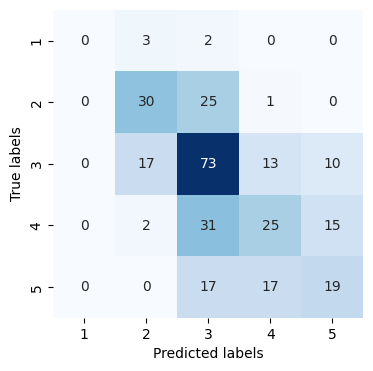

In [334]:
conf_matrix = confusion_matrix(y_test, y_test_prediction_svc, labels=None, sample_weight=None, normalize=None)
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1,6), yticklabels=range(1,6), cbar=None)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

##### Feature significance

#### 3.3. Ensemble: RandomForest

In [335]:
from sklearn.ensemble import RandomForestClassifier

In [336]:
param_grid = {'criterion': ['gini','entropy'],
              'n_estimators': range(5, 101, 10),
              'max_depth': range(2, 20,4),
              'max_features': ['auto', 'sqrt', 'log2']} # here, actually for the classifier 'auto' and 'sqrt' are same.

search_rf = GridSearchCV(RandomForestClassifier(random_state=21),
                  param_grid=param_grid,
                  cv=5,
                  verbose=2,
                  scoring = qwk_scorer,
                  )

search_rf.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 300 candidates, totalling 1500 fits
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=5; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=5; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=5; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=5; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=5; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=15; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=15; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=15; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=15; total time=   0.0s
[CV] END criterion=gini, max_depth=2, max_features=auto, n_estimators=15; total time=   0.0s
[CV] END cr

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:425: FitFailedWarning: 
500 fits failed out of a total of 1500.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
500 fits failed with the following error:
Traceback (most recent call last):
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/base.py", line 1145, in wrapper
    estimator._validate_params()
  File "/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=21),
             param_grid={'criterion': ['gini', 'entropy'],
                         'max_depth': range(2, 20, 4),
                         'max_features': ['auto', 'sqrt', 'log2'],
                         'n_estimators': range(5, 101, 10)},
             scoring=make_scorer(quadratic_weighted_kappa), verbose=2)

In [337]:
search_rf.best_params_

{'criterion': 'gini',
 'max_depth': 14,
 'max_features': 'sqrt',
 'n_estimators': 65}

In [338]:
y_test_prediction_rf = search_rf.best_estimator_.predict(ss.transform(X_test))

In [339]:
accuracy_score(y_test, y_test_prediction_rf)

0.44666666666666666

In [340]:
quadratic_weighted_kappa(y_test, y_test_prediction_rf)

0.5337785335420443

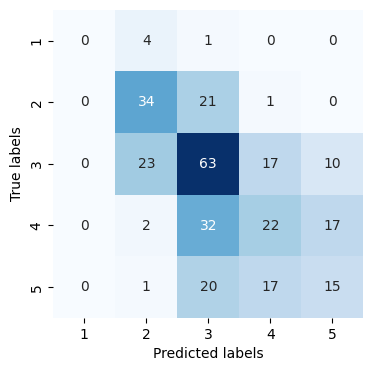

In [341]:
conf_matrix = confusion_matrix(y_test, y_test_prediction_rf, labels=None, sample_weight=None, normalize=None)
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1,6), yticklabels=range(1,6), cbar=None)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

#### 3.3. Ensemble: XGBoost

In [342]:
import xgboost as xgb

In [343]:
y_train_adjust = y_train-1

In [344]:
y_train_adjust

654    3
300    4
321    3
374    1
799    2
      ..
576    2
836    4
961    3
997    4
136    3
Name: score, Length: 700, dtype: int64

In [345]:
param_grid = {
    'n_estimators': range(20, 300, 30),
    'max_depth': range(2, 20, 4),
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0]
}

# Set up GridSearchCV
search_xgboost = GridSearchCV(
    estimator=xgb.XGBClassifier(
        use_label_encoder=False, eval_metric='mlogloss'),
        param_grid=param_grid, 
        cv=5, 
        n_jobs=-1, 
        verbose=2,
        scoring = qwk_scorer)

# Fit the grid search
search_xgboost.fit(X_train_scaled, y_train_adjust)

Fitting 5 folds for each of 450 candidates, totalling 2250 fits


Python(64153) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64154) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64155) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64156) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64157) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64158) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64159) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
Python(64160) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


[CV] END colsample_bytree=0.6, max_depth=2, n_estimators=20, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, max_depth=2, n_estimators=20, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, max_depth=2, n_estimators=20, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, max_depth=2, n_estimators=20, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, max_depth=2, n_estimators=20, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, max_depth=2, n_estimators=20, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, max_depth=2, n_estimators=20, subsample=0.8; total time=   0.1s
[CV] END colsample_bytree=0.6, max_depth=2, n_estimators=20, subsample=0.6; total time=   0.1s
[CV] END colsample_bytree=0.6, max_depth=2, n_estimators=20, subsample=0.8; total time=   0.0s
[CV] END colsample_bytree=0.6, max_depth=2, n_estimators=20, subsample=1.0; total time=   0.0s
[CV] END colsample_bytree=0.6, max_depth=2, n_esti

GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='mlogloss', feature_types=None,
                                     gamma=None, grow_policy=None,
                                     importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate...
                                     max_leaves=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None,
                                     random_state=None, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'max_depth': range(2, 20, 4),
                         'n_estimators': range(20, 300, 30),
                         'subsample': [0.6, 0.8, 1.0]},
             scoring=make_scorer(quadratic_weighted_kappa), verbose=2)

In [346]:
y_test_prediction_xgboost = search_xgboost.best_estimator_.predict(ss.transform(X_test))+1

In [347]:
accuracy_score(y_test, y_test_prediction_xgboost)

0.4666666666666667

In [348]:
quadratic_weighted_kappa(y_test, y_test_prediction_xgboost)

0.5334715639810426

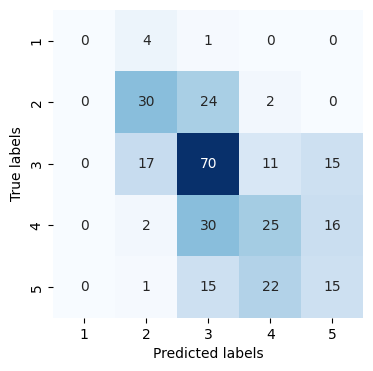

In [349]:
conf_matrix = confusion_matrix(y_test, y_test_prediction_xgboost, labels=None, sample_weight=None, normalize=None)
plt.figure(figsize=(4,4))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=range(1,6), yticklabels=range(1,6), cbar=None)
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()